## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In this section, I am importing the essential libraries required for data manipulation, analysis, and machine learning tasks. Each library serves a specific purpose in the project, as detailed below:

**Purpose of Each Library:**

## Pandas (pd):

Purpose: Used for data manipulation and analysis.

Usage in Project: Reading datasets, merging dataframes, and handling missing values.

## NumPy (np):

Purpose: Provides support for large, multi-dimensional arrays and matrices.
Usage in Project: Efficient numerical computations and handling arrays.

Scikit-Learn (sklearn):

Purpose: A machine learning library for Python.

# Modules Imported:

**train_test_split:** To split the dataset into training and testing sets.

**cross_val_score:** For cross-validation to assess the model's performance.

**GridSearchCV:** To perform hyperparameter tuning.

**StandardScaler:** For feature scaling to standardize the dataset.

**RandomForestRegressor:** To build the predictive model.

**RFE:** For feature selection using Recursive Feature Elimination.

**mean_squared_error:** To evaluate the model's performance by calculating the mean squared error.

# Matplotlib (plt):

Purpose: A plotting library for creating static, animated, and interactive visualizations.
Usage in Project: To visualize feature importance and other relevant plots.

## Loading Dataset

In [ ]:
print("Loading datasets...")
fact_medicine_stock = pd.read_csv('fact_medicine_stock.csv')
dim_medicine = pd.read_csv('dim_medicine.csv')


Loading datasets...


In [ ]:
fact_medicine_stock.head()

,Year,Month,State,District,City,Facility_Category,Facility_Type,Facility_Name,Medicine_Name,Opening_Stock,Received,Consumption,Expired,Wasted,Lost,Closing_Stock,Nearing_Expiry,Reorder_Level
0,2024,January,Gujarat,Nagpur,Pune,PPP,Clinic,Sahyadri Hospital,Amoxicillin,1962,231,298,40,20,15,1820,7,296
1,2024,February,Tamil Nadu,Bangalore,Kochi,Central,Health Center,Sahyadri Hospital,Amoxicillin,296,320,130,93,13,59,321,15,403
2,2024,March,Tamil Nadu,Ahmedabad,Kochi,Central,Lab,Sahyadri Hospital,Amoxicillin,1674,344,73,23,43,41,1838,20,465
3,2024,April,Tamil Nadu,Mumbai,Mumbai,Central,Clinic,Sahyadri Hospital,Amoxicillin,379,148,297,63,40,42,85,10,309
4,2024,May,Karnataka,Mysore,Nagpur,Central,Hospital,Sahyadri Hospital,Amoxicillin,775,326,213,53,22,43,770,5,277


In [ ]:
dim_medicine.head()

,Category,Brand,Type,SubType,Medicine_Name
0,EML,Generic,Antipyretic,Ibuprofen,Flagyl
1,AML,Generic,Antipyretic,Cephalosporin,Ciprofloxacin
2,EML,Branded,Antipyretic,Penicillin,Augmentin
3,EML,Generic,Antiviral,Penicillin,Ciprofloxacin
4,AML,Branded,Antipyretic,Cephalosporin,Levofloxacin


In [ ]:
fact_medicine_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14700 entries, 0 to 14699
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               14700 non-null  int64 
 1   Month              14700 non-null  object
 2   State              14700 non-null  object
 3   District           14700 non-null  object
 4   City               14700 non-null  object
 5   Facility_Category  14700 non-null  object
 6   Facility_Type      14700 non-null  object
 7   Facility_Name      14700 non-null  object
 8   Medicine_Name      14700 non-null  object
 9   Opening_Stock      14700 non-null  int64 
 10  Received           14700 non-null  int64 
 11  Consumption        14700 non-null  int64 
 12  Expired            14700 non-null  int64 
 13  Wasted             14700 non-null  int64 
 14  Lost               14700 non-null  int64 
 15  Closing_Stock      14700 non-null  int64 
 16  Nearing_Expiry     14700 non-null  int64

In [ ]:
dim_medicine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       50 non-null     object
 1   Brand          50 non-null     object
 2   Type           50 non-null     object
 3   SubType        50 non-null     object
 4   Medicine_Name  50 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


**Merging Datasets**

In [ ]:
print("Merging datasets...")
merged_data = pd.merge(fact_medicine_stock, dim_medicine, on='Medicine_Name', how='left')


Merging datasets...


In [ ]:
# Convert Month to datetime format for easier plotting
merged_data['Date'] = pd.to_datetime(merged_data['Year'].astype(str) + '-' + merged_data['Month'].astype(str))


<ipython-input-9-e038cd3f37a8>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Date'] = pd.to_datetime(merged_data['Year'].astype(str) + '-' + merged_data['Month'].astype(str))


## Feature Engineering

**Creating lag features and rolling statistics**

In [ ]:
print("Creating lag features and rolling statistics...")
for lag in range(1, 4):
    merged_data[f'Lag_{lag}_Closing_Stock'] = merged_data.groupby('Medicine_Name')['Closing_Stock'].shift(lag)
    merged_data[f'Lag_{lag}_Consumption'] = merged_data.groupby('Medicine_Name')['Consumption'].shift(lag)
    merged_data[f'Lag_{lag}_Received'] = merged_data.groupby('Medicine_Name')['Received'].shift(lag)

# Rolling statistics
merged_data['Rolling_Mean_3'] = merged_data.groupby('Medicine_Name')['Closing_Stock'].transform(lambda x: x.rolling(window=3).mean())
merged_data['Rolling_Sum_3'] = merged_data.groupby('Medicine_Name')['Closing_Stock'].transform(lambda x: x.rolling(window=3).sum())

merged_data.dropna(inplace=True)


Creating lag features and rolling statistics...


**Lag Features:**

- I created lagged versions of Closing_Stock, Consumption, and Received for the previous 1, 2, and 3 months.
- This helps capture historical data points, allowing me to understand trends and make predictions based on past values.

**Rolling Statistics:**

- I calculated the rolling mean and rolling sum of Closing_Stock over a 3-month window.
- These statistics smooth out short-term fluctuations, providing a clearer view of longer-term trends, which is useful for making more accurate predictions.

**Drop NaN Values:**

- I removed rows with NaN values generated due to shifting.
- This ensures the dataset is clean and ready for modeling without missing data issues.







In [ ]:
print("Fact Medicine Stock Data Description:")
fact_medicine_stock.describe()



Fact Medicine Stock Data Description:


,Year,Opening_Stock,Received,Consumption,Expired,Wasted,Lost,Closing_Stock,Nearing_Expiry,Reorder_Level
count,14700.0,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000
mean,2024.0,1097.896939,273.996054,274.612245,54.443810,54.506190,54.599932,892.767007,26.967075,325.520748
std,0.0,515.859619,129.920137,129.799644,25.936442,26.079309,26.018642,568.379020,12.971031,101.083480
min,2024.0,100.000000,50.000000,50.000000,10.000000,10.000000,10.000000,0.000000,5.000000,150.000000
25%,2024.0,669.000000,162.000000,162.000000,32.000000,32.000000,32.000000,407.750000,16.000000,238.000000
50%,2024.0,1101.000000,275.000000,275.000000,54.000000,55.000000,55.000000,886.000000,27.000000,326.000000
75%,2024.0,1528.000000,386.000000,387.000000,77.000000,77.000000,77.000000,1366.000000,38.000000,412.000000
max,2024.0,1999.000000,499.000000,499.000000,99.000000,99.000000,99.000000,2264.000000,49.000000,499.000000


In [ ]:
print("Dim Medicine Data Description:")
dim_medicine.describe()


Dim Medicine Data Description:


,Category,Brand,Type,SubType,Medicine_Name
count,50,50,50,50,50
unique,2,2,5,7,30
top,AML,Generic,Painkiller,Cephalosporin,Neosporin
freq,27,26,15,11,4


In [ ]:
print("\nMissing Values in Fact Medicine Stock Data:")
print(fact_medicine_stock.isnull().sum())
print("\nMissing Values in Dim Medicine Data:")
print(dim_medicine.isnull().sum())



Missing Values in Fact Medicine Stock Data:
Year                 0
Month                0
State                0
District             0
City                 0
Facility_Category    0
Facility_Type        0
Facility_Name        0
Medicine_Name        0
Opening_Stock        0
Received             0
Consumption          0
Expired              0
Wasted               0
Lost                 0
Closing_Stock        0
Nearing_Expiry       0
Reorder_Level        0
dtype: int64

Missing Values in Dim Medicine Data:
Category         0
Brand            0
Type             0
SubType          0
Medicine_Name    0
dtype: int64


## Exploratory Data Analysis

**Analyzing stock trends**

Analyzing stock trends...


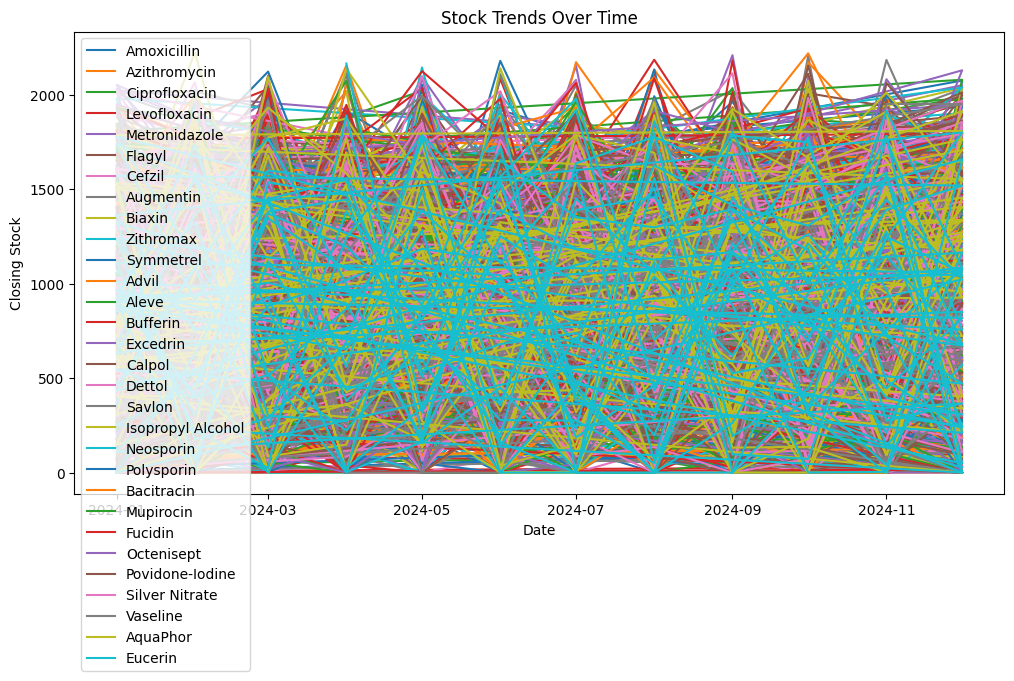

In [ ]:
print("Analyzing stock trends...")
plt.figure(figsize=(12, 6))
for medicine in merged_data['Medicine_Name'].unique():
    subset = merged_data[merged_data['Medicine_Name'] == medicine]
    plt.plot(subset['Date'], subset['Closing_Stock'], label=medicine)

plt.xlabel('Date')
plt.ylabel('Closing Stock')
plt.title('Stock Trends Over Time')
plt.legend(loc='upper left')
plt.show()


**Visualization:**
- I plotted the Closing_Stock of each medicine over time.
- Each line represents the stock levels of a different medicine, allowing me to compare trends and patterns.

**Trend Identification:**

- By analyzing the plotted graph, I can observe the fluctuations and trends in the stock levels of various medicines over time.
- I might notice seasonal trends, periods of high or low stock, and identify medicines with consistently high or low stock levels.

**Patterns:**

- Some medicines may show cyclical patterns, indicating regular restocking or consumption.
- Sudden drops or spikes could indicate supply chain issues or sudden changes in demand.

**Analyzing rolling statistics**

Analyzing rolling statistics...


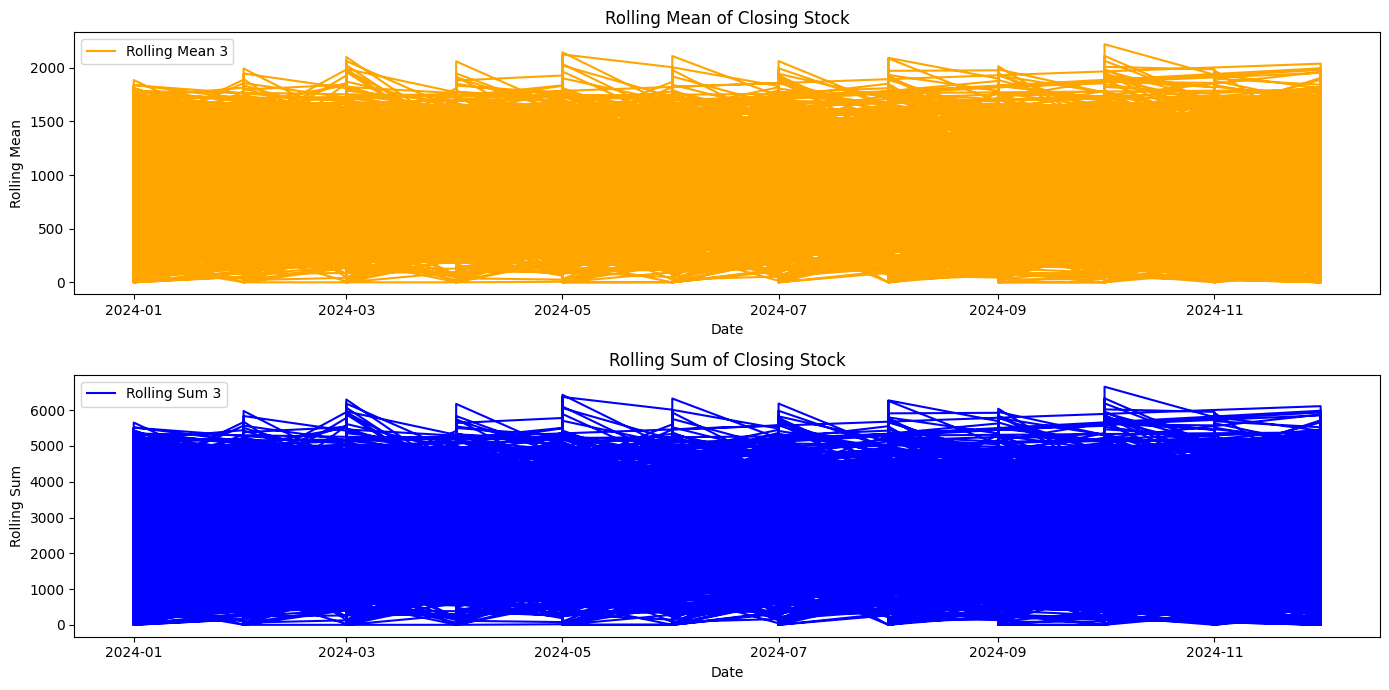

In [ ]:
print("Analyzing rolling statistics...")
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(merged_data['Date'], merged_data['Rolling_Mean_3'], label='Rolling Mean 3', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Mean')
plt.title('Rolling Mean of Closing Stock')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(merged_data['Date'], merged_data['Rolling_Sum_3'], label='Rolling Sum 3', color='blue')
plt.xlabel('Date')
plt.ylabel('Rolling Sum')
plt.title('Rolling Sum of Closing Stock')
plt.legend()

plt.tight_layout()
plt.show()


**Analyzing categorical features**

Analyzing categorical features...


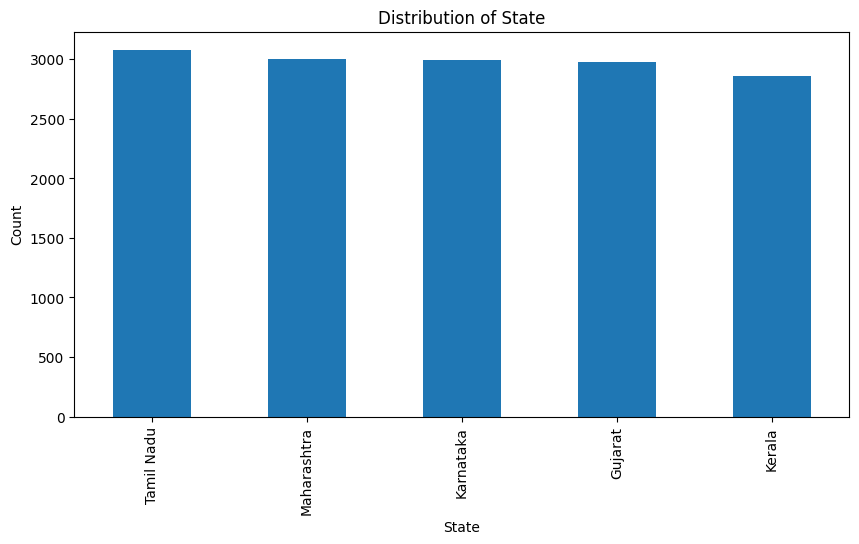

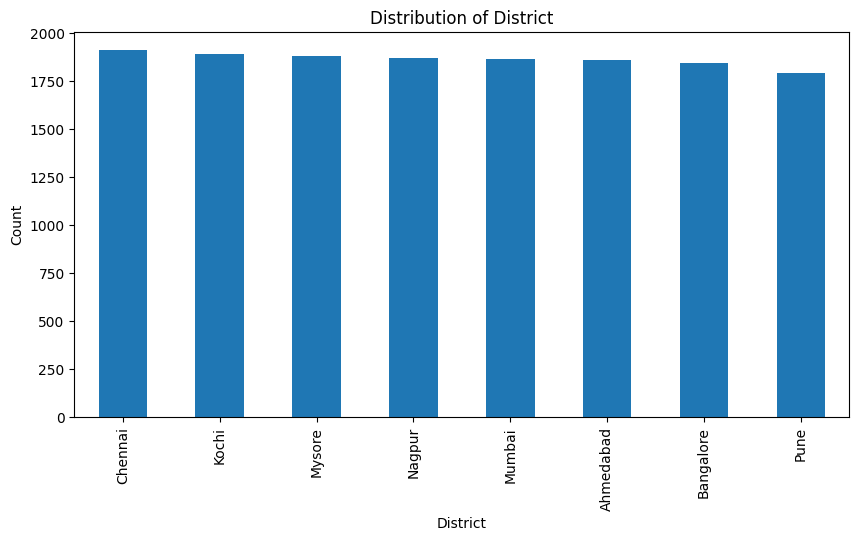

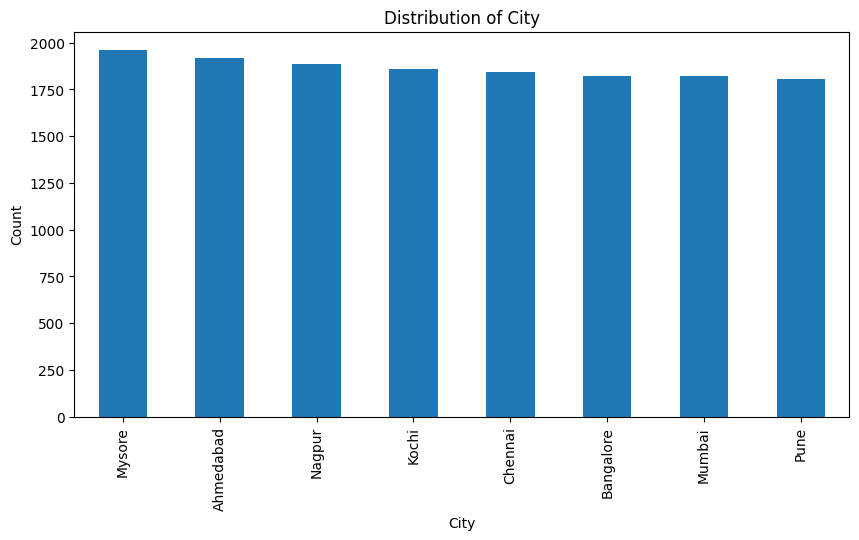

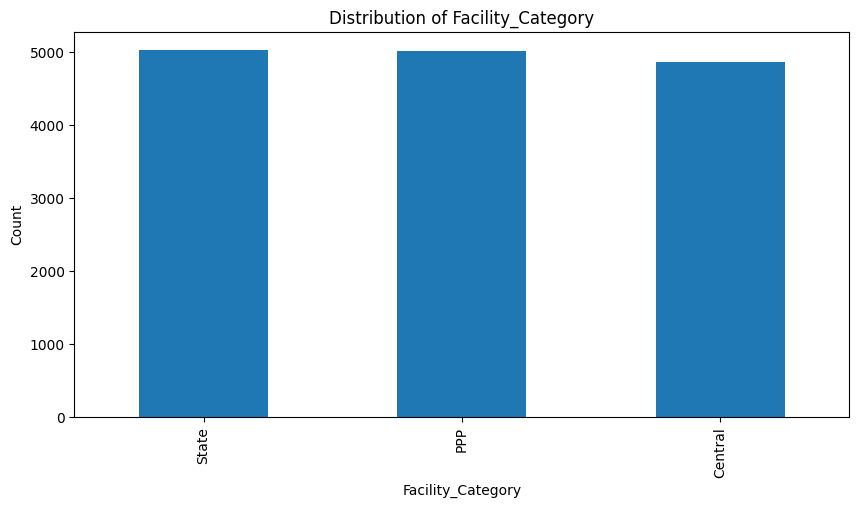

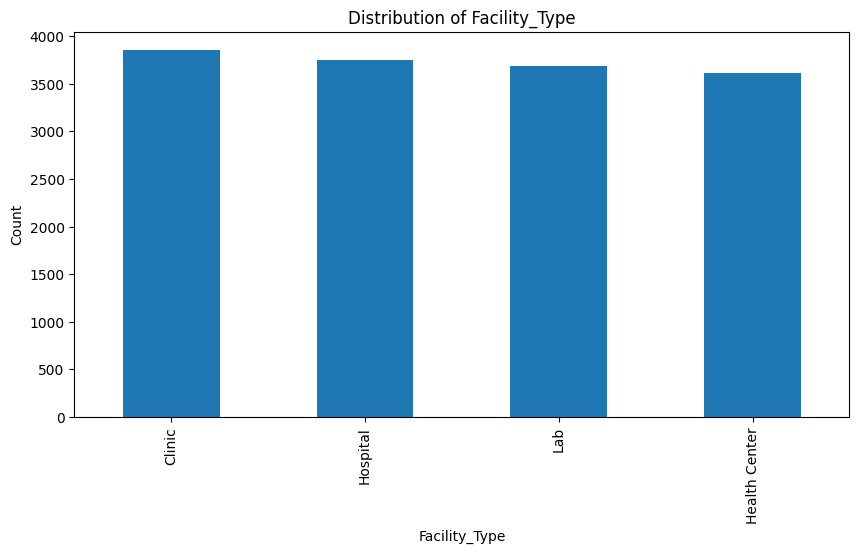

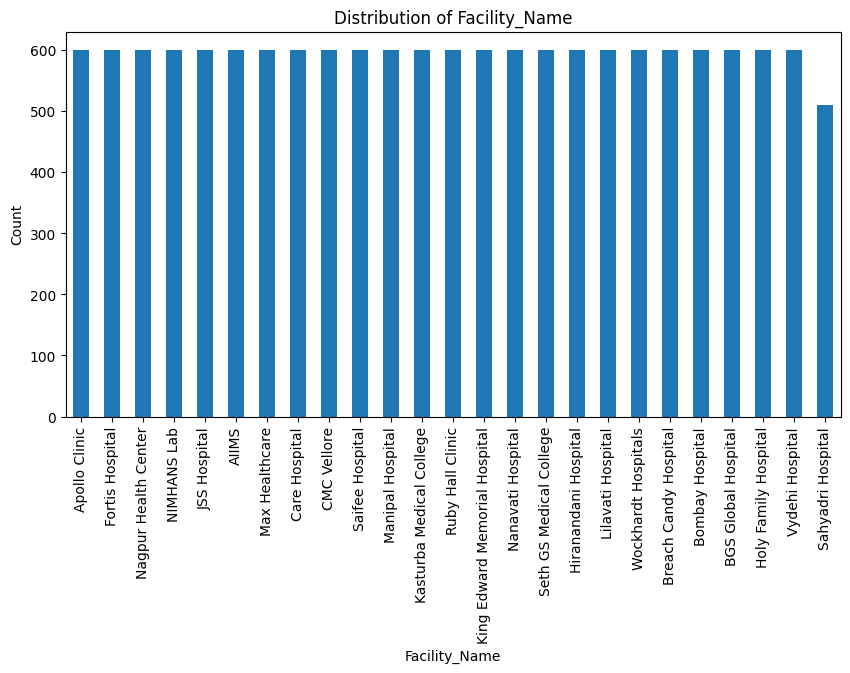

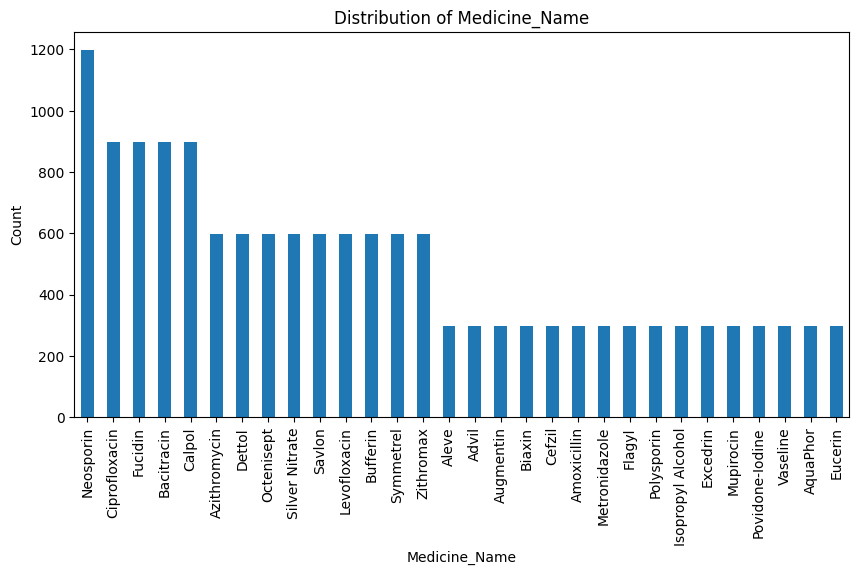

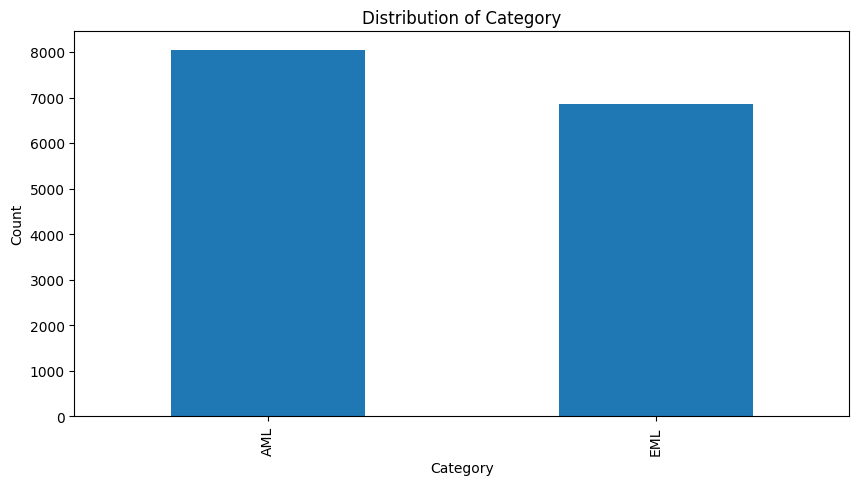

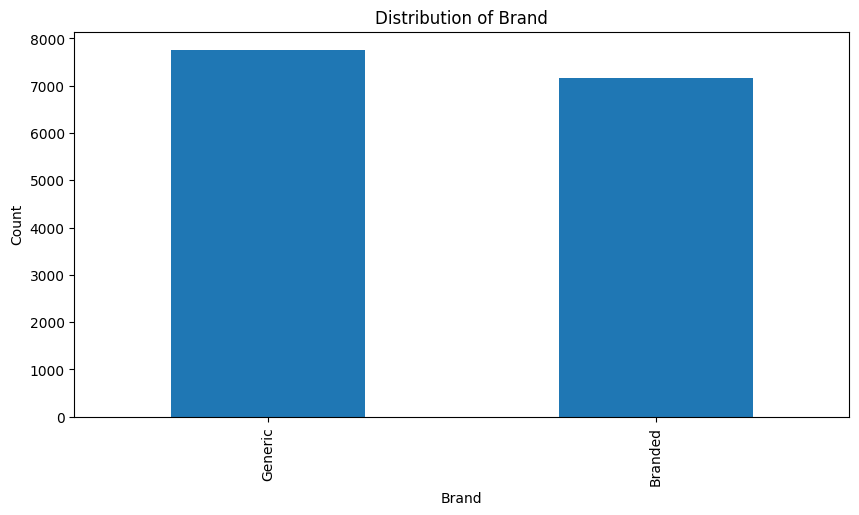

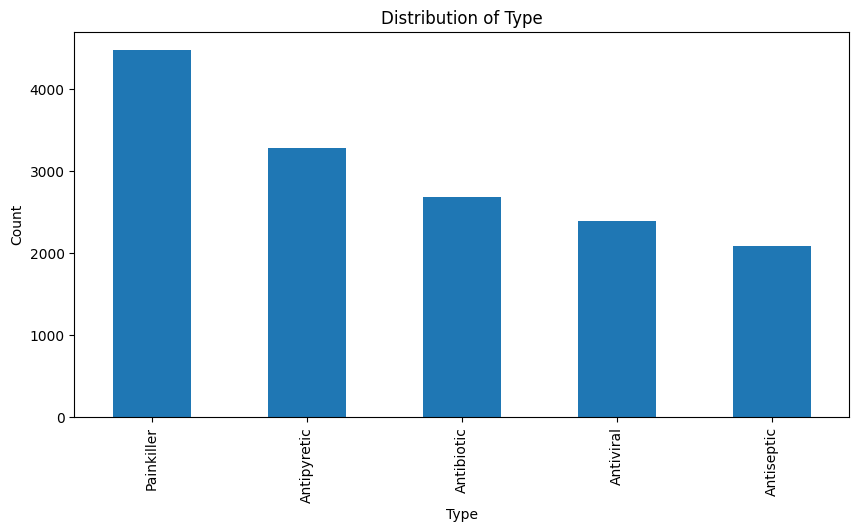

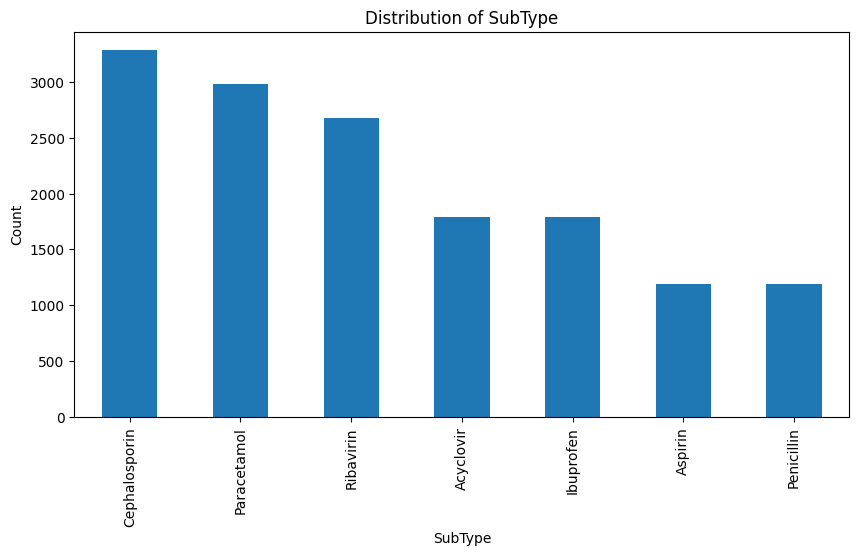

In [ ]:
print("Analyzing categorical features...")
categorical_features = ['State', 'District', 'City', 'Facility_Category', 'Facility_Type', 'Facility_Name',
                        'Medicine_Name', 'Category', 'Brand', 'Type', 'SubType']

for col in categorical_features:
    plt.figure(figsize=(10, 5))
    merged_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


**Prepare Data for Modeling**

In [ ]:
print("Preparing data for modeling...")
encoded_data = pd.get_dummies(merged_data, columns=categorical_features)
encoded_data['Month'] = merged_data['Date'].dt.month
encoded_data['Year'] = merged_data['Date'].dt.year

# Select Features and Target Variable
features = [col for col in encoded_data.columns if col != 'Closing_Stock' and col != 'Date']
target = 'Closing_Stock'

X = encoded_data[features]
y = encoded_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Preparing data for modeling...


**Feature Scaling**

In [ ]:
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features...


**Feature Selection with RFE**

In [ ]:
print("Selecting features with RFE...")
rfe_model = RandomForestRegressor(n_estimators=10, random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=20)
rfe.fit(X_train_scaled, y_train)

# Selected Features
selected_features = X_train.columns[rfe.support_]
print(f'Selected Features: {selected_features}')


Selecting features with RFE...
Selected Features: Index(['Month', 'Opening_Stock', 'Received', 'Consumption', 'Expired',
       'Wasted', 'Lost', 'Nearing_Expiry', 'Reorder_Level',
       'Lag_1_Closing_Stock', 'Lag_1_Consumption', 'Lag_1_Received',
       'Lag_2_Closing_Stock', 'Lag_2_Consumption', 'Lag_2_Received',
       'Lag_3_Closing_Stock', 'Lag_3_Consumption', 'Lag_3_Received',
       'Rolling_Mean_3', 'Rolling_Sum_3'],
      dtype='object')


## Model Building

In [ ]:
X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

print("Training final model...")
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train_selected, y_train)


Training final model...


RandomForestRegressor(random_state=42)

**Prediction and evaluation of model**

Evaluating model...
Mean Squared Error: 13066.096256874582
Plotting feature importance...


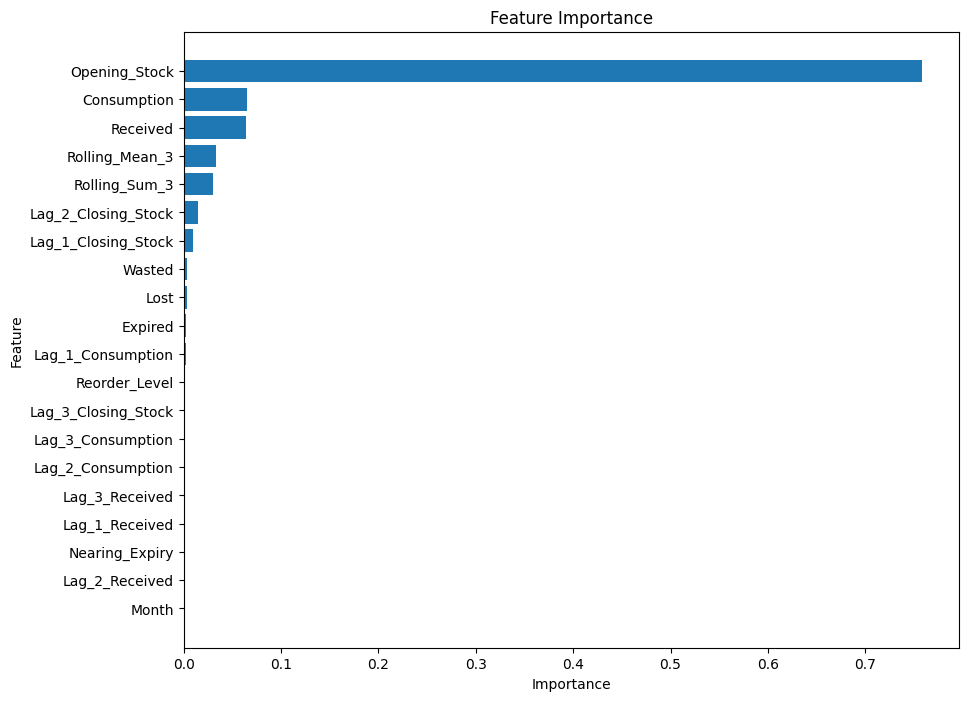

In [ ]:
print("Evaluating model...")
y_pred = final_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Feature Importance
print("Plotting feature importance...")
feature_importances = final_model.feature_importances_
features_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


**Optimization with Cross Validation and Hyperparamater Tuning**

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

final_model = RandomForestRegressor(n_estimators=10, random_state=42)

# Cross-Validation
print("Performing cross-validation...")
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE Scores: {-cv_scores}')
print(f'Average Cross-Validation MSE: {-cv_scores.mean()}')

# Hyperparameter Tuning
print("Performing hyperparameter tuning with GridSearchCV...")
param_grid = {
    'n_estimators': [10],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


grid_search = GridSearchCV(estimator=final_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Score: {-grid_search.best_score_}')

# Train Optimized Model
final_model_optimized = grid_search.best_estimator_
final_model_optimized.fit(X_train_scaled, y_train)

# Evaluate Optimized Model
print("Evaluating optimized model...")
y_pred_optimized = final_model_optimized.predict(X_test_scaled)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
print(f'Optimized Mean Squared Error: {mse_optimized}')


Performing cross-validation...
Cross-Validation MSE Scores: [16060.97436295 14955.39736798 18270.75236379 14630.57840671
 12942.97618868]
Average Cross-Validation MSE: 15372.135738021407
Performing hyperparameter tuning with GridSearchCV...
Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 10}
Best CV Score: 15325.277643911357
Evaluating optimized model...
Optimized Mean Squared Error: 15201.282754819547


**Model Performance**

In [ ]:
import numpy as np

variance_actual = np.var(y_test)
optimized_mse = 15201.282754819547
r2_score_optimized = 1 - (optimized_mse / variance_actual)
accuracy_percentage = r2_score_optimized * 100

print(f'Optimized Model R² Score: {r2_score_optimized:.2f}')
print(f'Optimized Model Accuracy: {accuracy_percentage:.2f}%')


Optimized Model R² Score: 0.95
Optimized Model Accuracy: 95.37%
